Training Mean Squared Error  164.154366165462
Testing Mean Squared Error  162.44120070080135
Training score:  0.18558460477509886
Testing score:  0.19306188758253484


/home/claire/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/claire/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


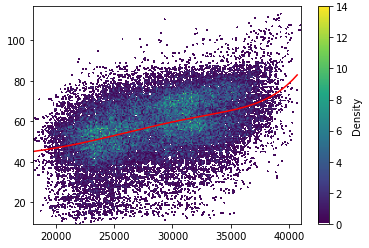

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
from sklearn.feature_selection import mutual_info_regression

#read the data
data = pd.read_csv('final_baseline_data.csv')

their_prediction = data['price day ahead']

data = data.drop(['generation fossil coal-derived gas', 'generation fossil oil shale', 
    'generation fossil peat', 'generation geothermal', 'generation marine', 
    'generation wind offshore', 'forecast solar day ahead', 'forecast wind onshore day ahead',
    'total load forecast', 'price day ahead'], axis = 1)
    
#set x and y values
y = data['price actual']
x = data['total load actual']


import numpy as np
import matplotlib.pyplot as plt
import mpl_scatter_density
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import operator
from sklearn.model_selection import train_test_split

#set up for density plots
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

#function for density plot
def scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap=white_viridis)
    fig.colorbar(density, label='Density')

from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

#polynomial regression using ridge regulation
def ridge(x, y, d):
    x_test, x_train, y_test, y_train = train_test_split(x, y, test_size = 0.2)
    p = PolynomialFeatures(degree = d)
    x_poly_test = p.fit_transform(x_test.values.reshape(-1, 1))
    x_poly_train = p.fit_transform(x_train.values.reshape(-1, 1))
    steps = [('poly', p), ('model', Ridge(alpha = 10, fit_intercept = True))]
    ridge_pipe = Pipeline(steps)
    ridge_pipe.fit(x_poly_train, y_train)
    y_train_pred = ridge_pipe.predict(x_poly_train)
    y_test_pred = ridge_pipe.predict(x_poly_test)

    print('Training Mean Squared Error ', mean_squared_error(y_train, y_train_pred))
    print('Testing Mean Squared Error ', mean_squared_error(y_test, y_test_pred))
    print('Training score: ', ridge_pipe.score(x_poly_train, y_train))
    print('Testing score: ', ridge_pipe.score(x_poly_test, y_test))

    fig = plt.figure()
    scatter_density(fig, x, y)
    sort_axis = operator.itemgetter(0)
    sorted_zip = sorted(zip(x_train, y_train_pred), key = sort_axis)
    x_poly_train, y_train_pred = zip(*sorted_zip)
    plt.plot(x_poly_train, y_train_pred, 'r')
    plt.show()

    return ridge_pipe, x_train, x_test, y_train, y_test

#get model
poly_reg = ridge(x, y, 3)